<a href="https://colab.research.google.com/github/SourabhKhamankar22/Chest-xray-Pneumonia-detection-using-CNN/blob/main/chest_xray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/Colab Notebooks/chest_xray pneumonia detection/archive.zip"
extract_path = '/content/chest_xray'

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

print("Extracted folders:", os.listdir(extract_path))

Extracted folders: ['chest_xray']


In [5]:
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [6]:
train_dir = '/content/chest_xray/chest_xray/train'
test_dir = '/content/chest_xray/chest_xray/test'

IMG_SIZE = (150, 150)
BATCH_SIZE = 32

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1,      # use 10% of training as validation
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

val_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


Found 4695 images belonging to 2 classes.
Found 521 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [8]:
classes = train_gen.classes
class_weights_values = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(classes),
    y=classes
)
class_weights_dict = {0: class_weights_values[0], 1: class_weights_values[1]}
print("Class weights:", class_weights_dict)


Class weights: {0: np.float64(1.9449047224523612), 1: np.float64(0.6730217889908257)}


In [9]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Dropout(0.4),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=5e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 74, 74, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 36, 36, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 17, 17, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,377 (18.42 MB)

 Trainable params: 4,828,929 (18.42 MB)

 Non-trainable params: 448 (1.75 KB)

In [10]:
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)


In [11]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[early_stop, reduce_lr]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 335s 2s/step - accuracy: 0.8199 - loss: 0.7412 - val_accuracy: 0.7428 - val_loss: 2.3582 - learning_rate: 5.0000e-05
Epoch 2/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 319s 2s/step - accuracy: 0.8803 - loss: 0.5508 - val_accuracy: 0.7428 - val_loss: 2.8432 - learning_rate: 5.0000e-05
Epoch 3/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 327s 2s/step - accuracy: 0.9012 - loss: 0.4946 - val_accuracy: 0.7428 - val_loss: 1.7314 - learning_rate: 5.0000e-05
Epoch 4/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 317s 2s/step - accuracy: 0.9137 - loss: 0.4607 - val_accuracy: 0.8637 - val_loss: 0.5081 - learning_rate: 5.0000e-05
Epoch 5/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 333s 2s/step - accuracy: 0.9253 - loss: 0.4446 - val_accuracy: 0.9232 - val_loss: 0.4195 - learning_rate: 5.0000e-05
Epoch 6/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 326s 2s/step - accuracy: 0.9370 - loss: 0.4206 - val_accuracy: 0.8848 - val_loss: 0.5098 - learning_rate: 5.0000e-05
Epoch 7/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 323s 2s/step - acc

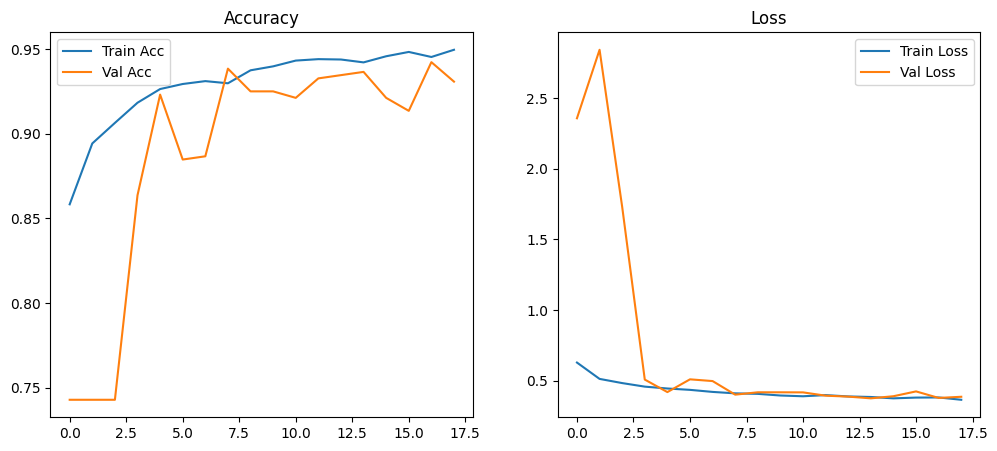

In [12]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title("Loss")

plt.show()


In [13]:
# Test evaluation
test_loss, test_acc = model.evaluate(test_gen)
print(f"\n Test Accuracy: {test_acc*100:.2f}%")
print(f" Test Loss: {test_loss:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 635ms/step - accuracy: 0.8371 - loss: 0.6436

 Test Accuracy: 87.98%
 Test Loss: 0.5421


In [14]:
# Get last epoch metrics
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]

print("Train Accuracy:", round(train_acc*100, 2), "%")
print("Val Accuracy:", round(val_acc*100, 2), "%")
print("Train Loss:", round(train_loss, 4))
print("Val Loss:", round(val_loss, 4))
print("--------------------------------------------------")

# Decision logic
acc_gap = abs(train_acc - val_acc)
loss_gap = abs(train_loss - val_loss)

if acc_gap < 0.03 and loss_gap < 0.05:
    print("✅ Model is well-generalized (Balanced).")
elif train_acc > val_acc and acc_gap >= 0.05:
    print("⚠️ Model is overfitting — try reducing epochs, increasing dropout, or adding augmentation.")
elif train_acc < val_acc and acc_gap >= 0.05:
    print("⚠️ Model is underfitting — try training longer or reducing dropout slightly.")
else:
    print("ℹ️ Model is borderline balanced — check plots to confirm.")


Train Accuracy: 94.97 %
Val Accuracy: 93.09 %
Train Loss: 0.365
Val Loss: 0.3863
--------------------------------------------------
✅ Model is well-generalized (Balanced).


20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 595ms/step - accuracy: 0.8371 - loss: 0.6436

📊 Test Accuracy: 87.98%
📉 Test Loss: 0.5421
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 599ms/step


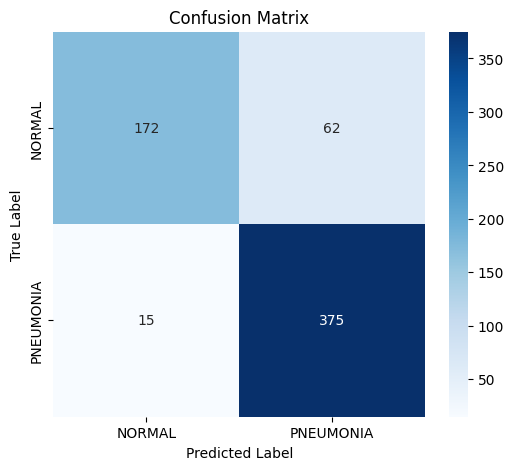


🧾 Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.92      0.74      0.82       234
   PNEUMONIA       0.86      0.96      0.91       390

    accuracy                           0.88       624
   macro avg       0.89      0.85      0.86       624
weighted avg       0.88      0.88      0.87       624



In [15]:
# ✅ Evaluate on test data
test_loss, test_acc = model.evaluate(test_gen, verbose=1)
print(f"\n📊 Test Accuracy: {test_acc*100:.2f}%")
print(f"📉 Test Loss: {test_loss:.4f}")

# ✅ Predictions
Y_pred = model.predict(test_gen)
threshold = 0.45
y_pred = (Y_pred > threshold).astype(int).ravel()
y_true = test_gen.classes

# ✅ Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(test_gen.class_indices.keys()), yticklabels=list(test_gen.class_indices.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ✅ Classification Report
print("\n🧾 Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys())))




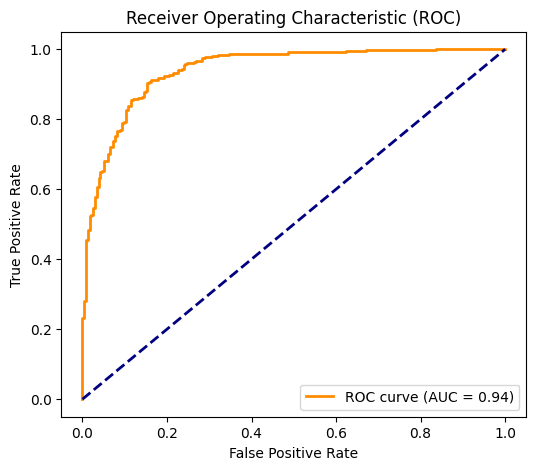

In [16]:
# ✅ ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_true, Y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('Receiver Operating Characteristic (ROC)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step


/tmp/ipython-input-3123201344.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f"True: {class_labels[int(label[idx])]} | Pred: {class_labels[int(pred[idx] > 0.5)]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step


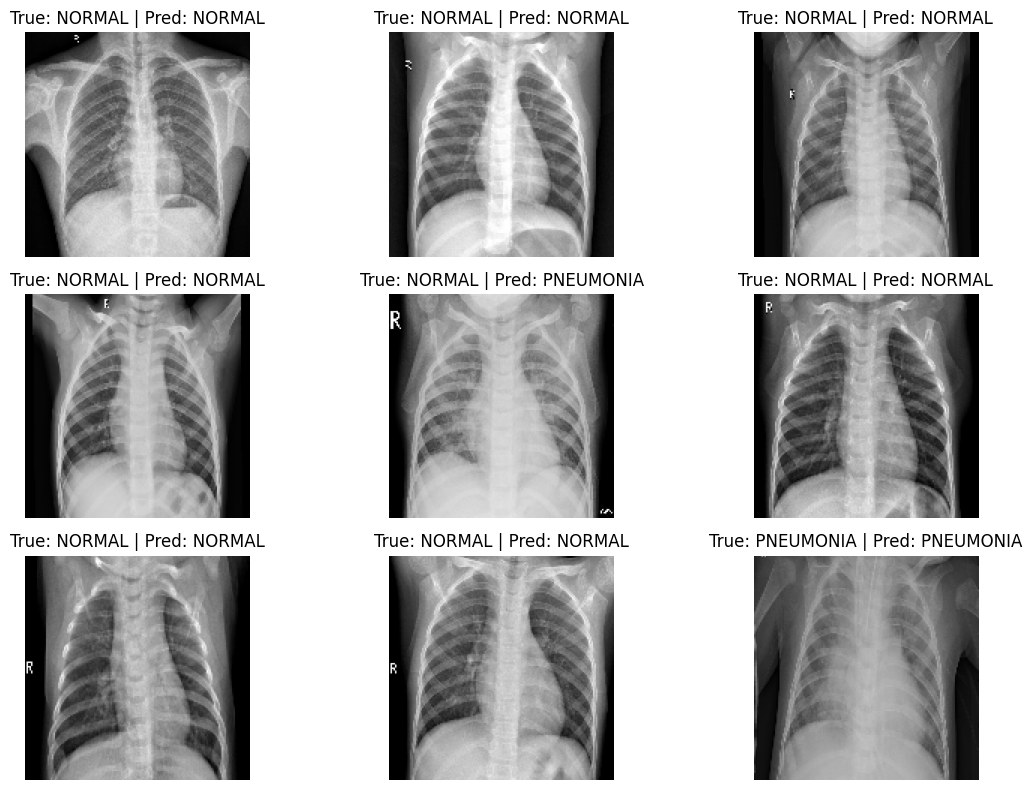

In [17]:

# ✅ Show a few sample predictions
class_labels = list(test_gen.class_indices.keys())
plt.figure(figsize=(12, 8))
for i in range(9):
    img, label = test_gen[i]
    pred = model.predict(img)
    idx = np.random.randint(0, len(img))
    plt.subplot(3, 3, i+1)
    plt.imshow(img[idx])
    plt.title(f"True: {class_labels[int(label[idx])]} | Pred: {class_labels[int(pred[idx] > 0.5)]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [18]:
model.save('/content/chest_xray_pneumonia_model.h5')
print("✅ Model saved successfully!")


✅ Model saved successfully!


In [19]:
# Load saved model (optional if session restarted)
model = load_model('/content/chest_xray_pneumonia_model.h5')

# Predict on any new image
img_path = '/content/chest_xray/chest_xray/test/NORMAL/IM-0091-0001.jpeg'  # update path
img = image.load_img(img_path, target_size=(150,150))
img_array = image.img_to_array(img)/255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)
if prediction[0][0] > 0.5:
    print("Predicted: PNEUMONIA")
else:
    print("Predicted: NORMAL")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
Predicted: NORMAL
